#### Analysing inside higher education capital campaign data - Capital Campaigns

The following dataset show the status of current fund-raising campaigns by colleges and universities, including their start and end dates; all gifts to higher education of at least USD 50 million, and the largest gift reported by each college and university.

- Objective of the notebook is to analyse insights from the data available on insidehighered website: http://www.insidehighered.com/capital_campaigns#
- Most common descriptive analysis on what has happened?

*NOTE: There is no enough data to perform predictive or prescriptive analysis


#### Questions: We have two sets of data to be exploited to form valuable insights:
1. Data 1: University campaign, goal, raised to date, duration and their priorities
    - KMeans Clusterin labelling Goal vs Raised for an association
    - University priorities to accumulate fund
    - Top and bottom Fundraising Universities and The Capital raised
    - Distribution of number of campaign years, Would long campaign raise more money?

2. Data 2: Donars giving more than USD 50 millions and their purpose
    - Amount of donation over the years?
    - Number of donars over the years?
    
3. Basic Natural Language Processing to identify hidden knowledge contrasting what universities need and donars expectations.
     - Bag of words model for the universities vs donars
     - word cloud contrasting university needs vs donars expectations.

Following data files: higherEd.xlsx with three sheets - 'Capital Campaign', 'Gifts over 50M USD', 'Largest gift by college'

In [2]:
# Load data

%matplotlib inline

from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
from pandas import ExcelWriter
from pandas import ExcelFile

### Let us create additional useful columns and fix missing values for dataset 1

- There are 82 rows and 9 columns
  - RangeIndex: 82 entries, 0 to 81
  - Data columns (total 9 columns):
      - College 82 non-null object - University or college name
      - Year Started 82 non-null int64 - Campaign start year
      - End Date 82 non-null int64 - Campaign End Year
      - Top priorities 82 non-null object - University fundraising priorities, text column
      - Ended 82 non-null bool - campaign ended or not, bool
      - Goal (USD millions) 82 non-null float64 - Goal in USD millions
      - Raised (USD millions) 82 non-null float64 - Raised to date in USD Millions
      - Years 82 non-null int64 - Number of campaign years
      - Raised Against Goal 82 non-null float64 - Substracting goal from raised

In [3]:
#Universities Data
uni = pd.read_excel('./input/higherEd.xlsx', sheetname='Capital Campaign')

# Create features, remove duplicates, adjust Nan values, define column datatypes

def replace(s, r1, r2):
    s = str(s).replace(r1,r2)
    return s

def fixdata(df):
    df['End Date'] = df.apply(lambda r: replace(r['End Date'], "No end date", '2020'), axis=1)
    df['Ended'] = df['End Date'].str.contains('Ended', regex=False)
    df['End Date'] = df.apply(lambda r: replace(r['End Date'], "Ended", ''), axis=1)
    df['Goal (USD millions)'] = (df['Goal'].astype(float)/1000000).astype(str)
    df['Raised (USD millions)'] = (df['Raised to Date'].astype(float)/1000000).astype(str)
    df = df.drop(['Goal', 'Raised to Date'], axis=1)
    df = df.astype({"College": str, "End Date": int,"Top priorities": str, "Goal (USD millions)": float, "Raised (USD millions)": float, "Ended": bool})
    df['No of Years'] = df['End Date'].sub(df['Year Started'], axis = 0)
    df['Raised Against Goal'] = df['Raised (USD millions)'].sub(df['Goal (USD millions)'], axis = 0)
    df['Raised (USD millions)'] = df['Raised (USD millions)'].fillna(17.0)
    df['Raised Against Goal'] = df['Raised Against Goal'].fillna(0)
    return df

uni = fixdata(uni)
uni.info()
uni.head(n=15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 9 columns):
College                  82 non-null object
Year Started             82 non-null int64
End Date                 82 non-null int32
Top priorities           82 non-null object
Ended                    82 non-null bool
Goal (USD millions)      82 non-null float64
Raised (USD millions)    82 non-null float64
No of Years              82 non-null int64
Raised Against Goal      82 non-null float64
dtypes: bool(1), float64(3), int32(1), int64(2), object(2)
memory usage: 5.0+ KB


,College,Year Started,End Date,Top priorities,Ended,Goal (USD millions),Raised (USD millions),No of Years,Raised Against Goal
0,Amherst College,2018,2023,"Student aid, a new science center, growth of t...",False,625.0,333.0,5,-292.0
1,ArtCenter College of Design,2018,2020,"Scholarships, learning spaces",False,100.0,84.0,2,-16.0
2,Auburn University,2008,2018,Scholarships and endowed chairs,True,1000.0,1200.0,10,200.0
3,Baylor University,2018,2023,Endowments for student aid and faculty positions,False,1100.0,542.0,5,-558.0
4,Bucknell University,2012,2017,Student aid and academic endowments,True,500.0,513.0,5,13.0
5,California State University at Los Angeles,2018,2022,"Academic programs, student success programs",False,75.0,45.0,4,-30.0
6,Carleton College,2018,2021,"Financial aid, new learning facilities, experi...",False,400.0,315.7,3,-84.3
7,Central Michigan University,2019,2022,Programs related to student success,False,100.0,101.0,3,1.0
8,Centre College,2015,2019,Scholarship programs,True,200.0,210.0,4,10.0
9,Christendom College,2016,2018,"Chapel, endowment",False,40.0,45.0,2,5.0


### Let us create additional useful columns and fix missing values for dataset 2 - Donars Data

There are 120 rows and 4 columns, moved text data about primary purpose to donartext dataframe.

    Int64Index: 120 entries, 0 to 77
    Data columns (total 4 columns):
    Amount Given (USD millions)    120 non-null float64
    College                        120 non-null object
    Primary Purpose                120 non-null object
    Year                           120 non-null int64


In [6]:
#Donors Data (Donations over USD 50 millions)
don1 = pd.read_excel('./input/higherEd.xlsx', sheetname='Largest gift by college')
don2 = pd.read_excel('./input/higherEd.xlsx', sheetname='Gifts over 50M USD')

don1['Amount Given (USD millions)'] = (don1['Amount Given'].astype(float)/1000000).astype(float)
don1['Year'] = (don1['Year Given'].astype(int))
don1 = don1.drop(['Year Given', 'Amount Given'], axis=1)

don2['Amount Given (USD millions)'] = (don2['Amount Given'].astype(float)/1000000).astype(float)
don2 = don2.drop(['Amount Given'], axis=1)

donar = don1.append([don2])
donar = donar.drop_duplicates()
donartext = donar.filter(['Primary Purpose'], axis=1)
donartext = donartext.drop_duplicates()
donar.info()
donar.head(n=15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 77
Data columns (total 4 columns):
Amount Given (USD millions)    120 non-null float64
College                        120 non-null object
Primary Purpose                120 non-null object
Year                           120 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.7+ KB


,Amount Given (USD millions),College,Primary Purpose,Year
0,650.0,Broad Institute of Harvard University and Mass...,Psychiatric research,2014
1,600.0,California Institute of Technology,"To promote collaborative, interdisciplinary re...",2001
2,600.0,Columbia University,Medical school and New York-Presbyterian Hospital,2017
3,500.0,Oregon Health & Science University,Challenge/matching grant,2013
4,500.0,University of Oregon,New campus focused on acceleration of science,2016
5,500.0,"University of California, San Francisco",Planning a new hospital,2018
6,460.0,Olin College of Engineering,Creating the college,1997
7,400.0,Stanford UniversityTied,School for Humanities and Sciences,2001
8,400.0,Harvard University,Endowment for engineering program,2015
9,400.0,Stanford UniversityTied,Scholarships for graduate students,2016


In [7]:
donar = donar.drop(['Primary Purpose'], axis=1)
donar = donar.drop_duplicates()
donar = donar.drop([31, 67])

### Identifying and labelling hidden cluster using Kmeans on University Data

KMeans clustering is basically cluster with a nearest mean.

-  Unsupervised Learning to verify lables or association between Goal against raised to date.
-  plot kmeans labels against goal, raised and see if it shows cluster.

Note: excluding irrelevant columns such as 'College', 'Year Started', 'End Date', 'Top priorities', 'Raised Against Goal', 'Years'
Make sure it does not have Nan Values before applying K means

In [8]:
data = uni.drop(['College', 'Year Started', 'End Date', 'Top priorities', 'Raised Against Goal', 'No of Years'], axis=1)

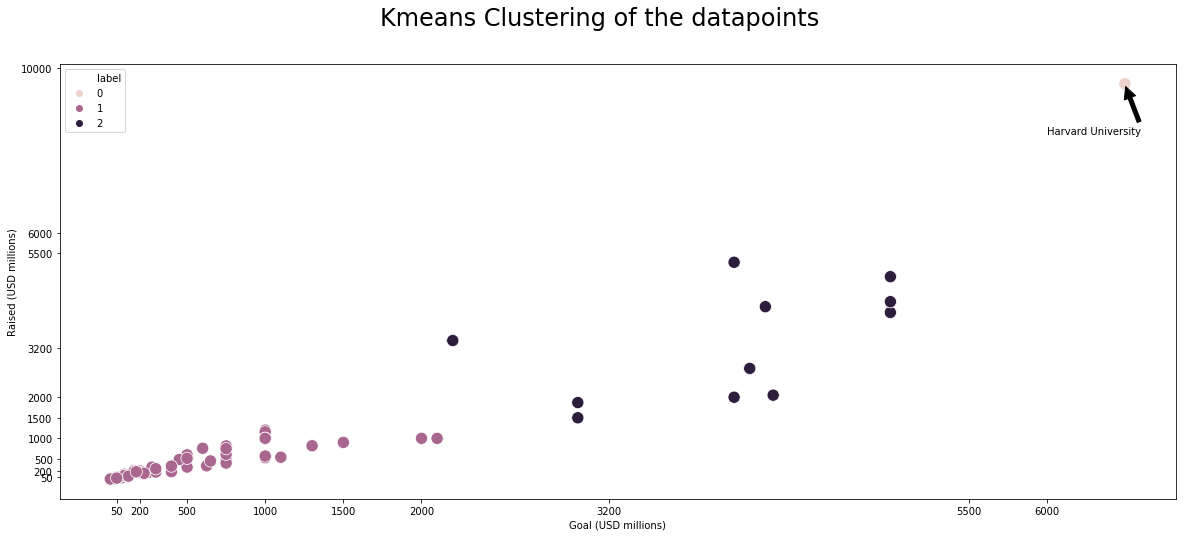

In [9]:
from sklearn.cluster import KMeans
from numpy.random import RandomState

kmeans = KMeans(n_clusters=3, random_state=RandomState(42)).fit(data)
data['label'] = pd.Series(kmeans.labels_, index=data.index)

plt.figure(figsize=(20,8))
plt.suptitle('Kmeans Clustering of the datapoints', fontsize=24)
plt.annotate('Harvard University', xy=(6500, 9600), xytext=(6000, 8400),arrowprops=dict(facecolor='black', shrink=0.05))
plt.xticks([50, 200, 500, 1000, 1500, 2000, 3200, 5500, 6000])
plt.yticks([50, 200, 500, 1000, 1500, 2000, 3200, 5500, 6000, 10000])
sns.scatterplot(x="Goal (USD millions)", y="Raised (USD millions)", s=150,hue='label' , data=data)

#### Insights based on Kmeans Clustering:
Kmeans divides sample of data into three clusters having raised against goal from low, medium, high.

1. Top most cluster 0, highest cluster showing maximum goal and raised more than planned which is only single observation or could be an outlier
2. Cluster 1, low cluster having small goal and fund raised
3. Custer 2, medium cluster having mid range goal and fund raised

Usually universities keep goal based on their expectations and mostly cluster 1 which is below USD 1000 millions whereas some universities keeping goal above USD 2000 which goes upto USD 6000 millions.


#### Scatter plot visualizing line fit - predictive scatter

Fitting line to this data shows reasonable scatter aroung line with one observed exception. It can be checked further later in analysis.

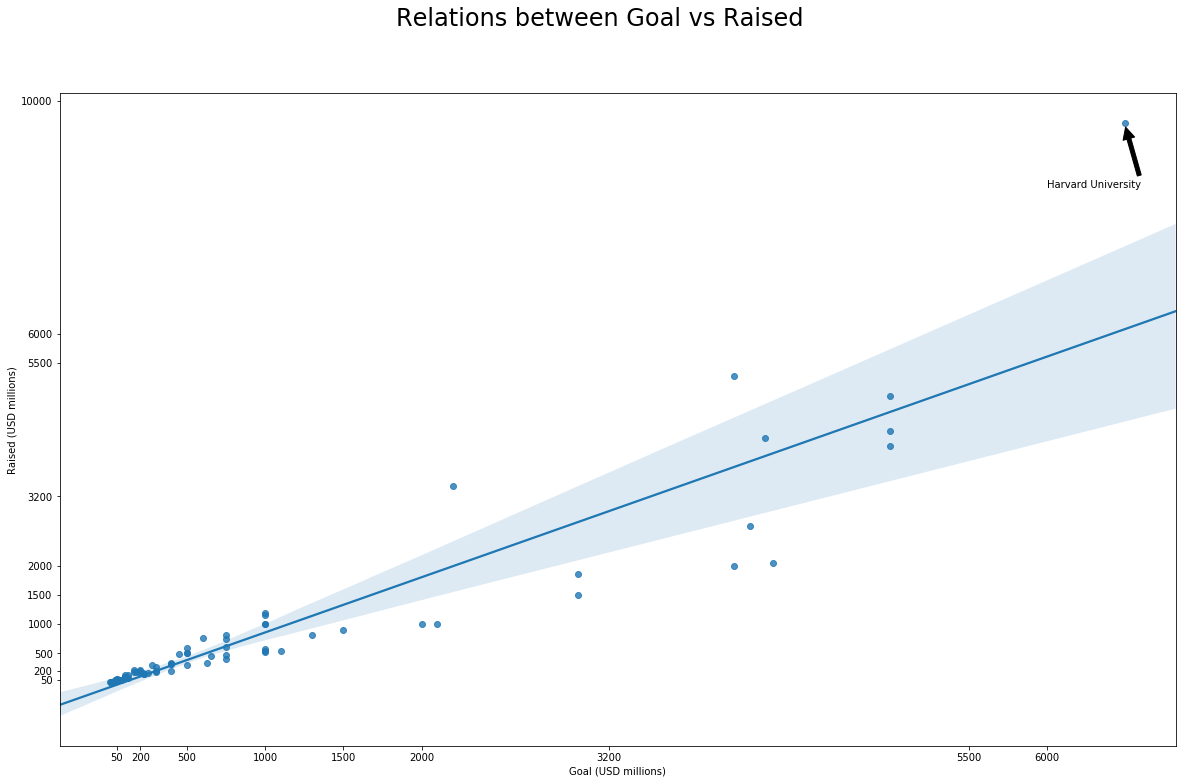

In [10]:
plt.figure(figsize=(20,12))
plt.suptitle('Relations between Goal vs Raised', fontsize=24)
plt.annotate('Harvard University', xy=(6500, 9600), xytext=(6000, 8500),arrowprops=dict(facecolor='black', shrink=0.05))
plt.xticks([50, 200, 500, 1000, 1500, 2000, 3200, 5500, 6000])
plt.yticks([50, 200, 500, 1000, 1500, 2000, 3200, 5500, 6000, 10000])
sns.regplot(x="Goal (USD millions)", y="Raised (USD millions)",data=data)

The outlier exception shown in data is for Harvard University raising tremendous amount of fund USD 9620.0 millions (approx 9.6 biilion) against planned goal USD 6500.0 millions topping it by USD 3120.0 millions in 5 years starting 2013 ending 2018 which can be validated from below university news article.

https://www.thecrimson.com/article/2018/4/15/capital-campaign-passes-9-billion/

Note: not penalising that row for now.

### Number of Universities can be divided into two groups:

1. Campaign already ended - 22 universities
2. Campaign not ended - 60

Since, data has many universities with campaign not ended. 

In [15]:
data['Ended'].value_counts()

False    60
True     22
Name: Ended, dtype: int64

### Performance of finished university campaings: 

At the end of the campaign, Most Universities have reported fund raised atleast what was planned. University of Michigan and Harvard University making most out of The Campaign.

<Figure size 2160x864 with 0 Axes>

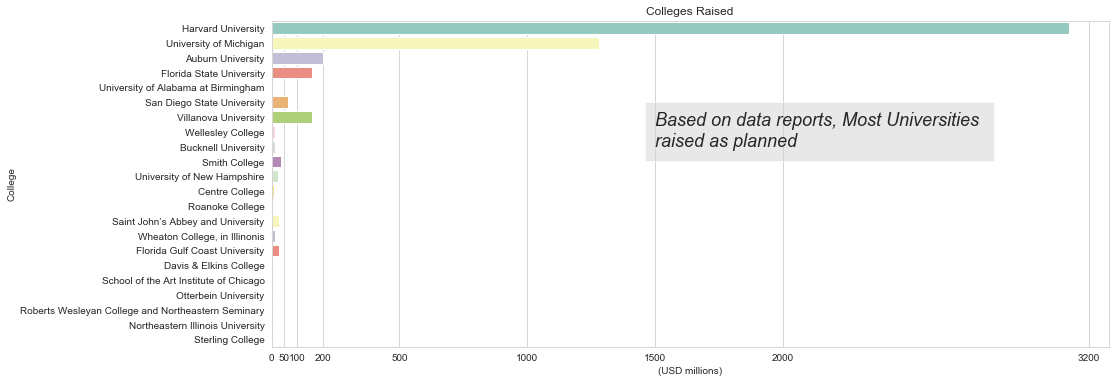

In [18]:
campEnded = uni.loc[uni['Ended'] == True].sort_values(by=['Raised (USD millions)'], ascending=False)

plt.figure(figsize=(30,12))
plt.suptitle('Top Performing Universities and Colleges(Campaign ended)', fontsize=24)


index = np.arange(22)
bar_width = 0.25
opacity = 0.8
plt.figure(figsize=(15,6))
sns.set_style('whitegrid')
sns.barplot(campEnded['Raised Against Goal'], campEnded['College'], palette="Set3")
plt.text(1500, 8, 'Based on data reports, Most Universities \nraised as planned', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
plt.xlabel('(USD millions)')
plt.title('Colleges Raised')
plt.xticks([0, 50, 100, 200, 500, 1000, 1500, 2000, 3200])
plt.show()

### Maximum donation receiving university list

These are the universities receiving largest donations based on donars data. John Hokins tops with USD 1800 millions followed by Harvard-MIT and then columbia.

<Figure size 2160x864 with 0 Axes>

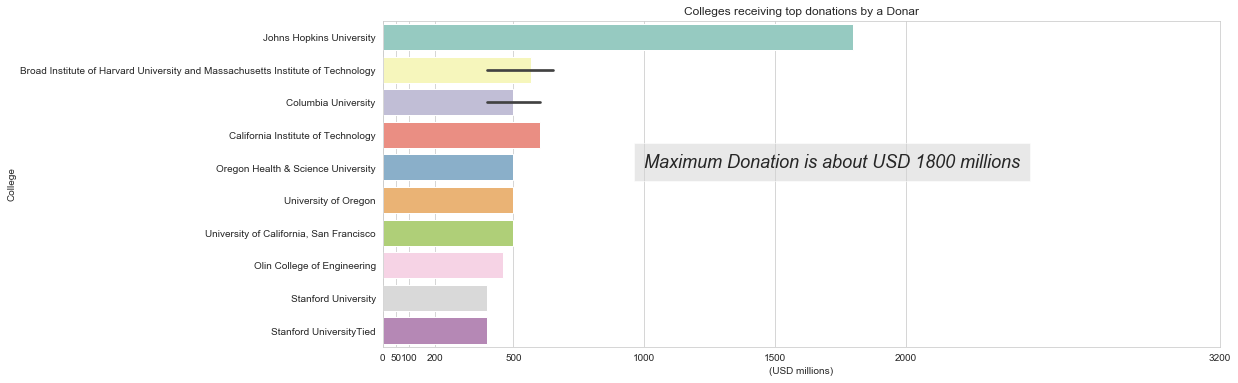

In [20]:
donartop = donar.sort_values(by=['Amount Given (USD millions)'], ascending=False).head(n=15)

plt.figure(figsize=(30,12))
#plt.suptitle('Top Performing Universities and Colleges(Campaign ended)', fontsize=24)


index = np.arange(22)
bar_width = 0.25
opacity = 0.8
plt.figure(figsize=(15,6))
sns.set_style('whitegrid')
sns.barplot(donartop['Amount Given (USD millions)'], donartop['College'], palette="Set3")
plt.text(1000, 4, 'Maximum Donation is about USD 1800 millions', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
plt.xlabel('(USD millions)')
plt.title('Colleges receiving top donations by a Donar')
plt.xticks([0, 50, 100, 200, 500, 1000, 1500, 2000, 3200])
plt.show()

### Number of years of campaign duration among Universities

Most of the universities do campaign from 2.5 years to 6 years keeping their raising goal approximately aroung USD 3000 millions.

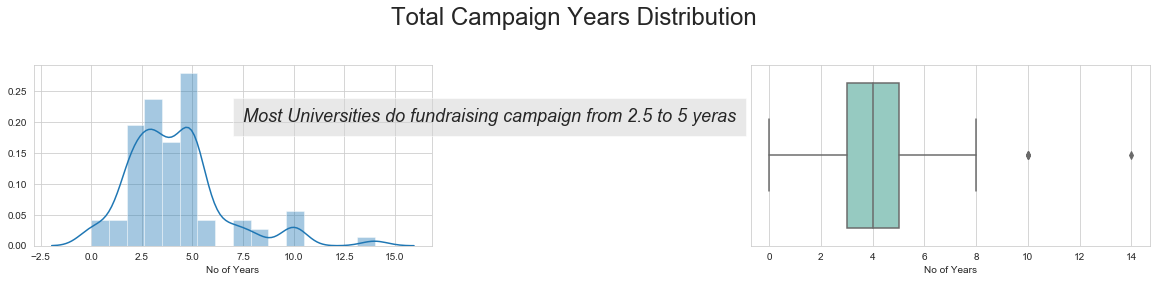

In [21]:
plt.figure(figsize=(20,8))
plt.suptitle('Total Campaign Years Distribution', fontsize=24)

plt.subplot(2,2,1)
sns.distplot(uni['No of Years'])
plt.text(7.5, 0.2, 'Most Universities do fundraising campaign from 2.5 to 5 yeras', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
plt.subplot(2,2,2)
sns.boxplot(x=uni['No of Years'], palette="Set3")
plt.subplots_adjust(hspace=0.2, wspace = 0.2 )

plt.subplots_adjust(hspace=0.4, wspace = 0.8)

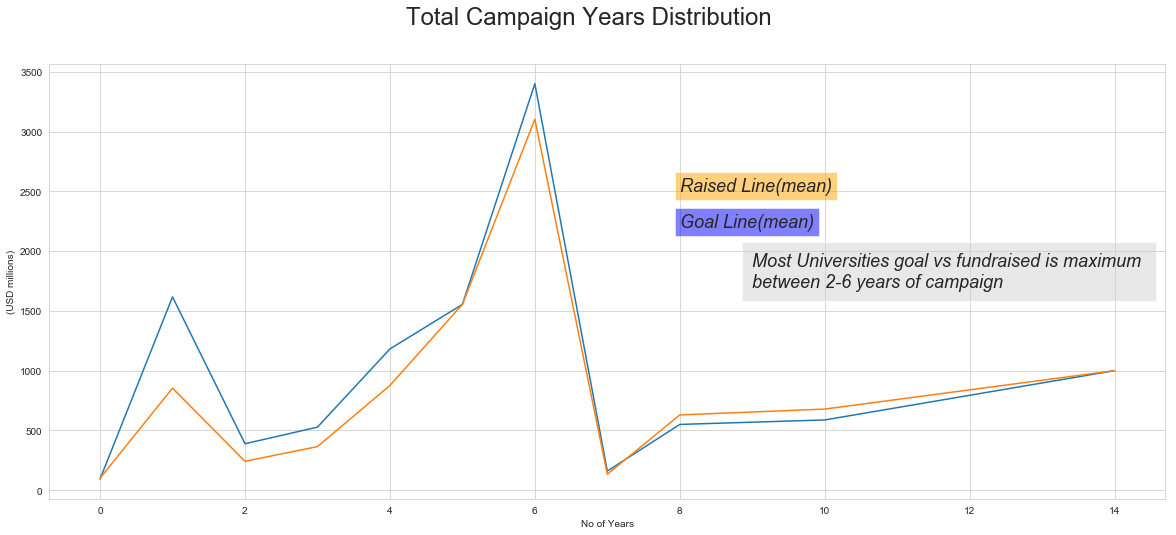

In [28]:
plt.figure(figsize=(20,8))
plt.suptitle('Total Campaign Years Distribution', fontsize=24)
plt.text(8, 2500, 'Raised Line(mean)', fontsize=18, style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 5})
plt.text(8, 2200, 'Goal Line(mean)', fontsize=18, style='italic', bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})
plt.text(9, 1700, 'Most Universities goal vs fundraised is maximum \nbetween 2-6 years of campaign', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
newdf = uni.groupby(['No of Years'], as_index=False)['Goal (USD millions)'].mean()
sns.lineplot(x="No of Years", y="Goal (USD millions)", data=newdf)

newdf = uni.groupby(['No of Years'], as_index=False)['Raised (USD millions)'].mean()
sns.lineplot(x="No of Years", y="Raised (USD millions)", data=newdf)
plt.ylabel("(USD millions)")
plt.subplots_adjust(hspace=0.4, wspace = 0.8)

### Quick look at number of prospective donars around the states

Findings in below donars plots:
- Number of donors have been incresed since 2015 as there is peek in 2019 which 35 of them donating more than USD 50 millions.
- Increase is number can be easily seen with decrease in average amount of donation.

Please ignore year 2019, 2020 points as there is not data present to show.

Text(2000,1500,'Number of donors increasing over years')

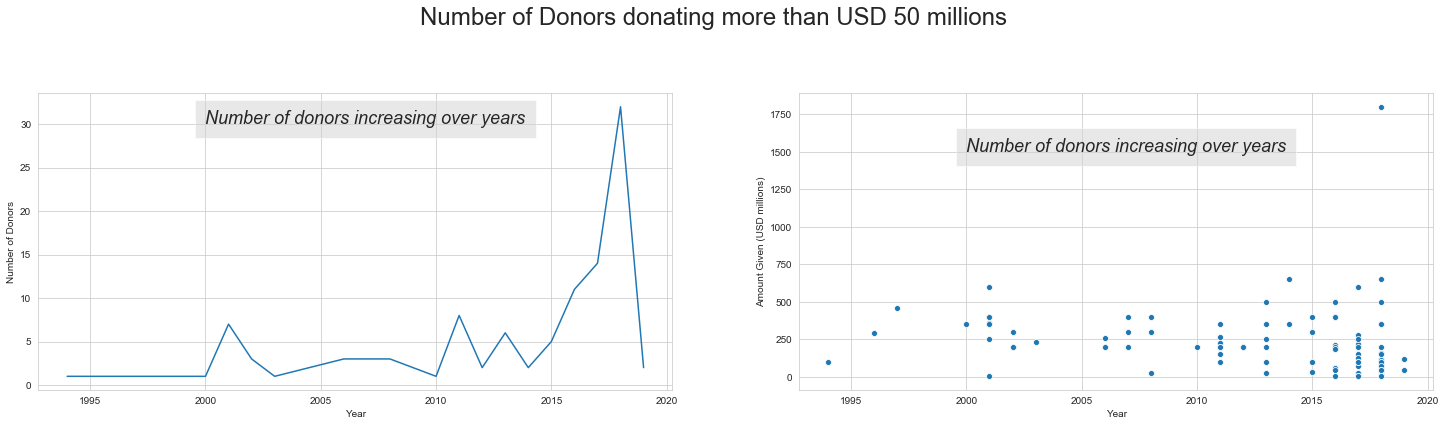

In [30]:
plt.figure(figsize=(25,12))
plt.suptitle('Number of Donors donating more than USD 50 millions', fontsize=24)

plt.subplot(2,2,1)
newdf = donar.groupby(['Year'], as_index=False).count()

sns.lineplot(x="Year", y="Amount Given (USD millions)", data=newdf)
plt.text(2000, 30, 'Number of donors increasing over years', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})
plt.ylabel("Number of Donors")
plt.subplot(2,2,2)

sns.scatterplot(x="Year", y="Amount Given (USD millions)", data=donar)
plt.text(2000, 1500, 'Number of donors increasing over years', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})

Text(2013,400,'Decrease in average donation per donar')

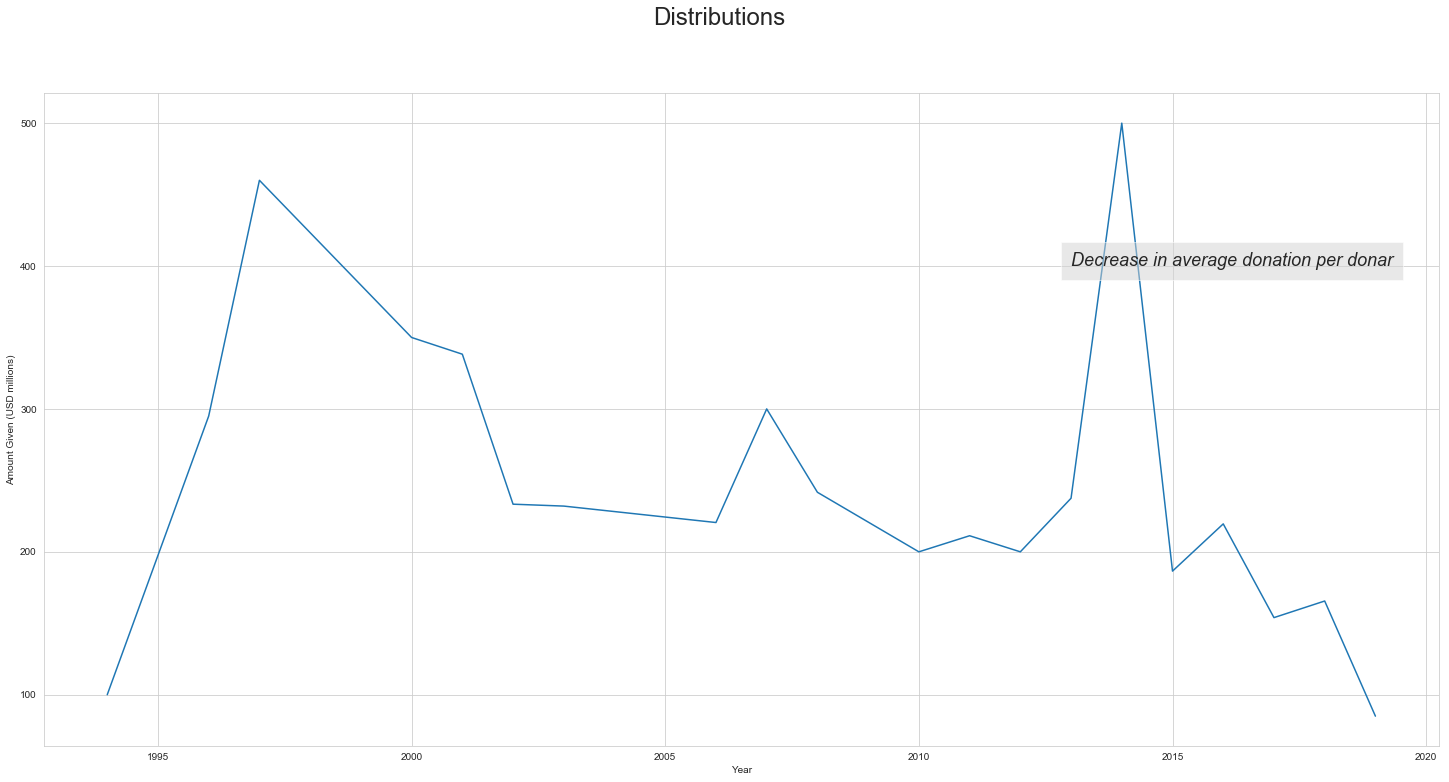

In [33]:
plt.figure(figsize=(25,12))
plt.suptitle('Distributions', fontsize=24)

newdf = donar.groupby(['Year'], as_index=False)['Amount Given (USD millions)'].mean()
sns.lineplot(x="Year", y="Amount Given (USD millions)", data=newdf)
plt.text(2013, 400, 'Decrease in average donation per donar', fontsize=18, style='italic', bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'pad': 10})

### Looking at top and bottom performing unimversities 

These list can be used to compare and contrast university campaign strategies against the university performin good and bad during their campaigns.

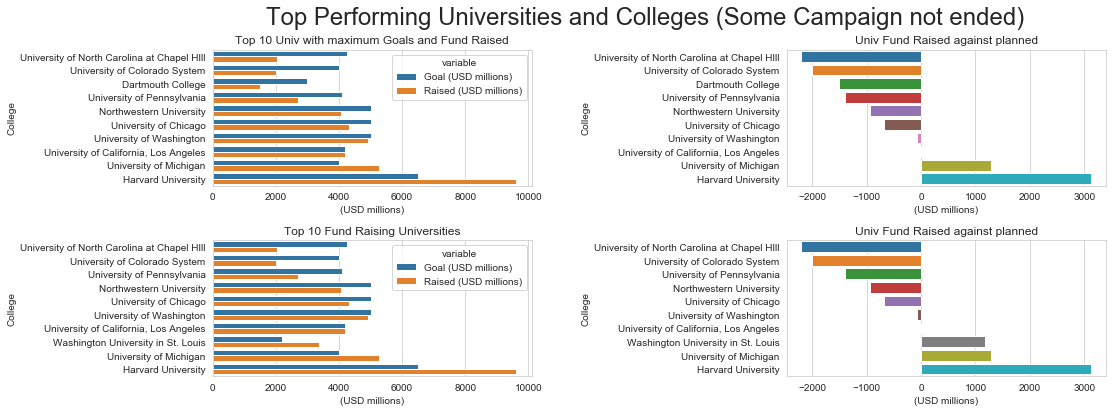

In [35]:
# Top 10 Universities exceeded goal including Campaign Not Ended
dftop = uni.sort_values(by=['Goal (USD millions)'], ascending=False).head(n=10)
index = np.arange(10)
bar_width = 0.25
opacity = 0.8

plt.figure(figsize=(16,6))
plt.suptitle('Top Performing Universities and Colleges (Some Campaign not ended)', fontsize=24)


plt.subplot(2,2,1)
sns.set_style('whitegrid')
testtop = pd.melt(dftop, id_vars=['College','Year Started','End Date','Top priorities','Ended','No of Years','Raised Against Goal']).sort_values(['variable','value'])
testtop = testtop.sort_values(by=['Raised Against Goal'], ascending=True)

sns.barplot(x='value', y='College', hue='variable', data=testtop)
plt.xlabel('(USD millions)')
plt.title('Top 10 Univ with maximum Goals and Fund Raised')

plt.subplot(2,2,2) 
sns.set_style('whitegrid')
sns.barplot(testtop['Raised Against Goal'], testtop['College'])
plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')

# Top 10 Universities max raised including Campaign not Ended
dftop2 = uni.sort_values(by=['Raised (USD millions)'], ascending=False).head(n=10)


plt.subplot(2,2,3) 
sns.set_style('whitegrid')
testtop2 = pd.melt(dftop2, id_vars=['College','Year Started','End Date','Top priorities','Ended','No of Years','Raised Against Goal']).sort_values(['variable','value'])
testtop2 = testtop2.sort_values(by=['Raised Against Goal'], ascending=True)

sns.barplot(x='value', y='College', hue='variable', data=testtop2)
plt.xlabel('(USD millions)')
plt.title('Top 10 Fund Raising Universities')

plt.subplot(2,2,4) 
sns.set_style('whitegrid')    
sns.barplot(testtop2['Raised Against Goal'], testtop2['College'])

plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')

plt.subplots_adjust(hspace=0.4, wspace = 0.8)

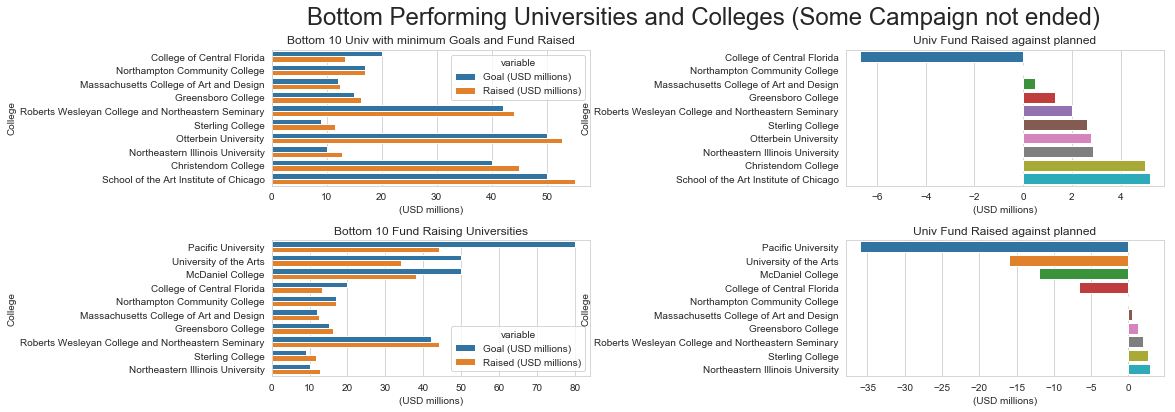

In [20]:
# Bottom 10 Universities including Campaign Not Ended
dfbottom = uni.sort_values(by=['Goal (USD millions)'], ascending=False).tail(n=10)
index = np.arange(10)
bar_width = 0.25
opacity = 0.8

plt.figure(figsize=(16,6))
plt.suptitle('Bottom Performing Universities and Colleges (Some Campaign not ended)', fontsize=24)

plt.subplot(2,2,1)
sns.set_style('whitegrid')
testbtm = pd.melt(dfbottom, id_vars=['College','Year Started','End Date','Top priorities','Ended','No of Years','Raised Against Goal']).sort_values(['variable','value'])
testbtm = testbtm.sort_values(by=['Raised Against Goal'], ascending=True)

sns.barplot(x='value', y='College', hue='variable', data=testbtm)
plt.xlabel('(USD millions)')
plt.title('Bottom 10 Univ with minimum Goals and Fund Raised')
plt.subplot(2,2,2) 
sns.set_style('whitegrid')
sns.barplot(testbtm['Raised Against Goal'], testbtm['College'])
plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')

# Top 10 Universities max raised including Campaign not Ended
dfbottom2 = uni.sort_values(by=['Raised (USD millions)'], ascending=False).tail(n=10)


plt.subplot(2,2,3) 
sns.set_style('whitegrid')
testbtm2 = pd.melt(dfbottom2, id_vars=['College','Year Started','End Date','Top priorities','Ended','No of Years','Raised Against Goal']).sort_values(['variable','value'])
testbtm2 = testbtm2.sort_values(by=['Raised Against Goal'], ascending=True)

sns.barplot(x='value', y='College', hue='variable', data=testbtm2)
plt.xlabel('(USD millions)')
plt.title('Bottom 10 Fund Raising Universities')

plt.subplot(2,2,4) 
sns.set_style('whitegrid')    
sns.barplot(testbtm2['Raised Against Goal'], testbtm2['College'])

plt.xlabel('(USD millions)')
plt.title('Univ Fund Raised against planned')

plt.subplots_adjust(hspace=0.4, wspace = 0.8)

In [ ]:
#x = df.sort_values(by=['Raised (USD millions)'], ascending=False)
#x= x.drop([23])
#x.head()

Natural Language Processing:

This notebook goes through a necessary step of any data science project - data cleaning. Data cleaning is a time consuming and unenjoyable task, yet it's a very important one. Keep in mind, "garbage in, garbage out". Feeding dirty data into a model will give us results that are meaningless.

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

**Common data cleaning steps on all text:**
* Make text all lower case
* Remove punctuation
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words
* Stemming / lemmatization

**More data cleaning steps after tokenization:**
* Parts of speech tagging
* Create bi-grams or tri-grams
* Deal with typos
* And more...

Specifically, we'll be walking through:

1. **Cleaning the data - **we will walk through popular text pre-processing techniques
2. **Organizing the data - **we will organize the cleaned data into a way that is easy to input into other algorithms


In [74]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from textblob import TextBlob
import string
import re

stop_words = set(stopwords.words('english')) 

def _clean(txt):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    txt = txt.lower()
    # punctuation removal 
    txt = ''.join(x for x in txt if x not in string.punctuation)
    txt = re.sub('\[.*?\]', ' ', txt)
    txt = re.sub('[%s]' % re.escape(string.punctuation), ' ', txt)
    txt = re.sub('\w*\d\w*', ' ', txt)
    txt = re.sub('[‘’“”…]', ' ', txt)
    txt = re.sub('\n', ' ', txt)
    txt = re.sub(r"\ba\b","",txt)
    # stopwords removal  
    word_tokens = word_tokenize(txt)    
    clean_txt = [w for w in word_tokens if not w in stop_words]  
    clean_txt = ""
  
    for w in word_tokens:
        if w not in stop_words:
            clean_txt += " "
            clean_txt += w 
    
    clean_txt = ' '.join(clean_txt.split()) # Removing multiple whitespaces
    noise = ['students','my','title', 'would', 'every', 'will','and', 'for', 'many','also','donotremoveessaydivider']
    for ns in noise:
        clean_txt = clean_txt.replace(ns, "")

    return clean_txt

newdf = uni.sort_values(by=['Raised (USD millions)'], ascending=False).filter(['Top priorities'], axis=1)
newdf['Top priorities'] = newdf['Top priorities'].apply(_clean)
donartext['Primary Purpose'] = donartext['Primary Purpose'].apply(_clean)

Another popular text analysis technique is called topic modeling. The ultimate goal of topic modeling is to find various topics that are present in your corpus. Each document in the corpus will be made up of at least one topic, if not multiple topics.

In this notebook, we will be covering the steps on how to do **Latent Dirichlet Allocation (LDA)**, which is one of many topic modeling techniques. It was specifically designed for text data.

To use a topic modeling technique, you need to provide (1) a document-term matrix and (2) the number of topics you would like the algorithm to pick up.

Once the topic modeling technique is applied, your job as a human is to interpret the results and see if the mix of words in each topic make sense. If they don't make sense, you can try changing up the number of topics, the terms in the document-term matrix, model parameters, or even try a different model.

In [82]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
#data_clean = pd.read_pickle('data_clean.pkl')

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(newdf['Top priorities'])
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = newdf.index

# Pickle it for later use

#import pickle
#pickle.dump(cv, open("cv_stop.pkl", "wb"))
#data_stop.to_pickle("dtm_stop.pkl")

In [83]:
# Import the necessary modules for LDA with gensim
# Terminal / Anaconda Navigator: conda install -c conda-forge gensim
from gensim import matutils, models
import scipy.sparse

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [84]:
# One of the required inputs is a term-document matrix
tdm = data_stop.transpose()
tdm.head()

,23,63,72,56,55,33,77,69,67,57,...,37,39,30,70,31,21,11,32,29,50
academic,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
afdability,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aid,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,1,0,0,1,0,0
arts,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
athletic,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [86]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [87]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.097*"scholarships" + 0.080*"endowed" + 0.047*"chairs" + 0.043*"aid" + 0.042*"new" + 0.041*"academic" + 0.036*"learning" + 0.035*"financial" + 0.032*"endowments" + 0.031*"programs"'),
 (1,
  '0.179*"student" + 0.151*"aid" + 0.059*"research" + 0.052*"faculty" + 0.048*"support" + 0.048*"programs" + 0.028*"success" + 0.020*"arts" + 0.019*"professorships" + 0.015*"endowment"')]

In [88]:
# LDA for num_topics = 3
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.147*"scholarships" + 0.137*"endowed" + 0.076*"chairs" + 0.045*"faculty" + 0.034*"support" + 0.027*"positions" + 0.023*"endowments" + 0.022*"research" + 0.020*"programs" + 0.019*"creation"'),
 (1,
  '0.056*"new" + 0.050*"learning" + 0.047*"endowment" + 0.040*"growth" + 0.033*"complex" + 0.033*"spaces" + 0.029*"teaching" + 0.028*"scholarships" + 0.020*"facilities" + 0.019*"academic"'),
 (2,
  '0.181*"student" + 0.174*"aid" + 0.060*"programs" + 0.050*"research" + 0.048*"faculty" + 0.038*"support" + 0.038*"financial" + 0.030*"academic" + 0.027*"success" + 0.018*"arts"')]

In [ ]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

In [ ]:
newdf.sort_values(by=['Raised (USD millions)'], ascending=False).head(n=5)

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Zipf's Law: Let f(w) be the frequency of a word w in free text. Suppose that all the words of a text are ranked according 
to their frequency, with the most frequent word first. Zipf's law states that the frequency of a word type is inversely proportional to its rank (i.e. f × r = k, for some constant k). For example, the 50th most common word type should occur three times as frequently as the 150th most common word type.

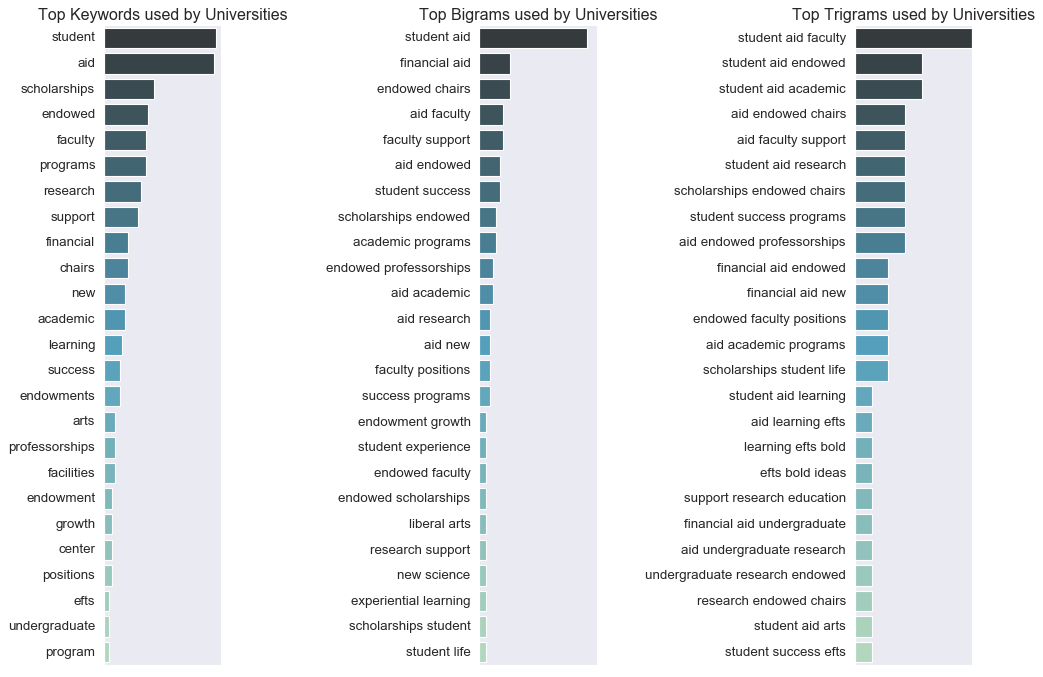

In [75]:
#s_copy = df.copy()
import pandas as pd
plt.style.use('classic')
### Bag of Words 
from collections import Counter
def generate_ngrams(txt, N):
    grams = [txt[i:i+N] for i in range(len(txt)-N+1)]
    grams = [" ".join(b) for b in grams]
    return grams 

newdf['unigrams'] = pd.DataFrame(newdf['Top priorities'].apply(lambda x : generate_ngrams(x.split(), 1)))
newdf['bigrams'] = pd.DataFrame(newdf['Top priorities'].apply(lambda x : generate_ngrams(x.split(), 2)))
newdf['trigrams'] = pd.DataFrame(newdf['Top priorities'].apply(lambda x : generate_ngrams(x.split(), 3)))

all_unigrams = []
for each in newdf['unigrams']:
    all_unigrams.extend(each)
t = Counter(all_unigrams).most_common(25)
x = [a[0] for a in t]
y = [a[1] for a in t]

all_bigrams = []
for each in newdf['bigrams']:
    all_bigrams.extend(each)
t1 = Counter(all_bigrams).most_common(25)
x1 = [a[0] for a in t1]
y1 = [a[1] for a in t1]


all_trigrams = []
for each in newdf['trigrams']:
    all_trigrams.extend(each)
t2 = Counter(all_trigrams).most_common(25)
x2 = [a[0] for a in t2]
y2 = [a[1] for a in t2]

sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=5, squeeze=True, figsize = (14,10));

bar = sns.barplot(y=x, x=y, ax=axes[0], palette='GnBu_d', edgecolor="white");
bar.set(xlabel='', xticks=[]);
axes[0].set_title("Top Keywords used by Universities");

fig.delaxes(axes[1]);

bar1 = sns.barplot(y=x1, x=y1, ax=axes[2], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[2].set_title("Top Bigrams used by Universities");

fig.delaxes(axes[3]);

bar1 = sns.barplot(y=x2, x=y2, ax=axes[4], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[4].set_title("Top Trigrams used by Universities");

plt.subplots_adjust(hspace=0.2, wspace = 0.6)

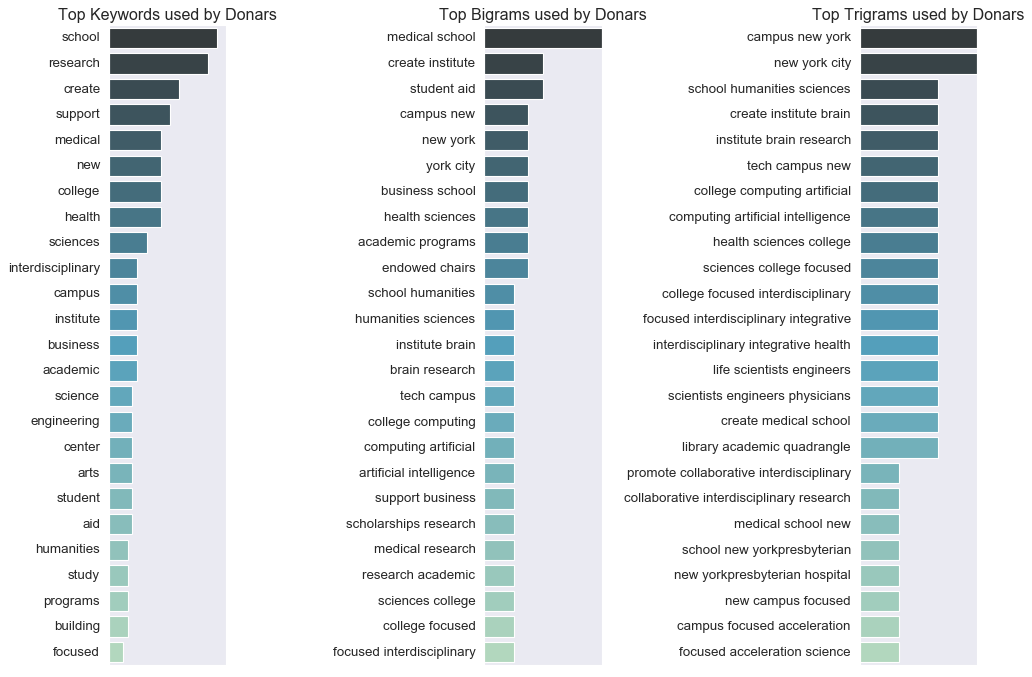

In [81]:
#s_copy = df.copy()
import pandas as pd
plt.style.use('classic')
### Bag of Words 
from collections import Counter
def generate_ngrams(txt, N):
    grams = [txt[i:i+N] for i in range(len(txt)-N+1)]
    grams = [" ".join(b) for b in grams]
    return grams 

donartext['unigrams'] = pd.DataFrame(donartext['Primary Purpose'].apply(lambda x : generate_ngrams(x.split(), 1)))
donartext['bigrams'] = pd.DataFrame(donartext['Primary Purpose'].apply(lambda x : generate_ngrams(x.split(), 2)))
donartext['trigrams'] = pd.DataFrame(donartext['Primary Purpose'].apply(lambda x : generate_ngrams(x.split(), 3)))

all_unigrams = []
for each in donartext['unigrams']:
    all_unigrams.extend(each)
t = Counter(all_unigrams).most_common(25)
x = [a[0] for a in t]
y = [a[1] for a in t]

all_bigrams = []
for each in donartext['bigrams']:
    all_bigrams.extend(each)
t1 = Counter(all_bigrams).most_common(25)
x1 = [a[0] for a in t1]
y1 = [a[1] for a in t1]


all_trigrams = []
for each in donartext['trigrams']:
    all_trigrams.extend(each)
t2 = Counter(all_trigrams).most_common(25)
x2 = [a[0] for a in t2]
y2 = [a[1] for a in t2]

sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=5, squeeze=True, figsize = (14,10));

bar = sns.barplot(y=x, x=y, ax=axes[0], palette='GnBu_d', edgecolor="white");
bar.set(xlabel='', xticks=[]);
axes[0].set_title("Top Keywords used by Donars");

fig.delaxes(axes[1]);

bar1 = sns.barplot(y=x1, x=y1, ax=axes[2], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[2].set_title("Top Bigrams used by Donars");

fig.delaxes(axes[3]);

bar1 = sns.barplot(y=x2, x=y2, ax=axes[4], palette='GnBu_d', edgecolor="white");
bar1.set(xlabel='', xticks=[]);
axes[4].set_title("Top Trigrams used by Donars");

plt.subplots_adjust(hspace=0.2, wspace = 0.6)

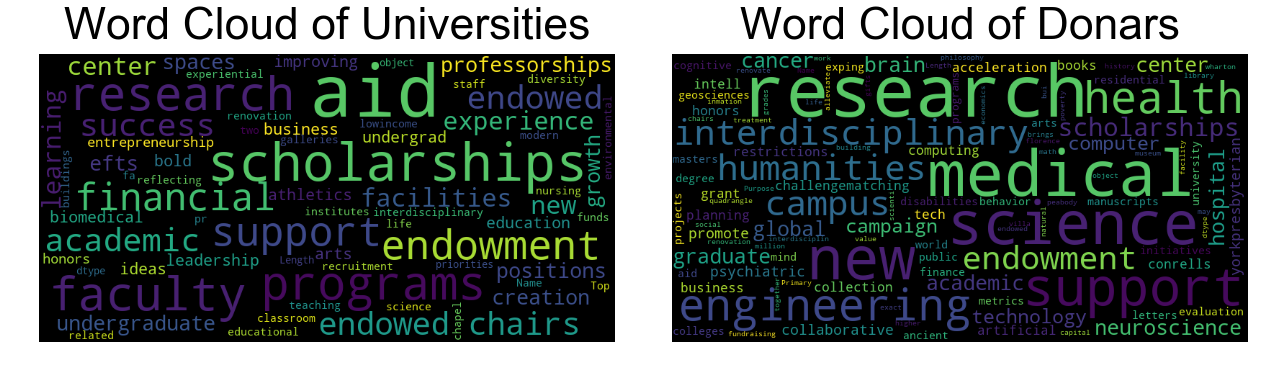

In [79]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'school', 'student', 'students', 'college', 'program', 'create', 'institute', 'study', 'matching', 'york',
                      'creating', 'city', 'department', 'rare', 'focused', 'miami'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    #plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    

plt.figure(figsize=(16,10))
#plt.suptitle('Bottom Performing Universities and Colleges (Some Campaign not ended)', fontsize=24)

plt.subplot(2,2,1)
plot_wordcloud(newdf["Top priorities"], title="Word Cloud of Universities")

plt.subplot(2,2,2)
plot_wordcloud(donartext["Primary Purpose"], title="Word Cloud of Donars")

Let us start with understaing universities top priorities by using Natuaral Language Processing Techniques, Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.

Steps to perfrom:
1. Clean text, remove punctuations, special characters and numbers, remove unneeded spaces
2. Create Document term matrix excluding stop words. DTM is basically a count of each word with respect to each row for word column.

In [ ]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('[‘’“”…]', ' ', text)
    text = re.sub('\n', ' ', text)
    text = ' '.join(text.split()) # Removing multiple whitespaces
    return text

round1 = lambda x: clean_text_round1(x)

# Let's take a look at the updated text
data_clean = pd.DataFrame(df['Top priorities'].apply(round1))
data_clean.head()

In [ ]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words(and, on, to,for etc...)
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean['Top priorities'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm.head()

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,8))
plt.suptitle('Distributions', fontsize=24, fontweight='bold')

plt.subplot(2,2,1)
#plt.xticks([9, 350, 1000, 2000, 3000, 4000, 5000, 6500])
#plt.xlabel('Purchase amount', fontsize=18)
sns.distplot(df['Goal (USD millions)'])

plt.subplot(2,2,2)
#plt.xticks([11, 801, 2000, 3000, 3000, 5000, 7000, 8000, 9000, 10000])
sns.distplot(df['Raised (USD millions)'])

plt.subplot(2,2,3)
#plt.xticks([9, 350, 1000, 2000, 3000, 4000, 5000, 6500])
sns.boxplot(x=df['Goal (USD millions)'],  palette="Set3")

plt.subplot(2,2,4)
#plt.xticks([11, 801, 2000, 3000, 3000, 5000, 7000, 8000, 9000, 10000])
sns.boxplot(x=df['Raised (USD millions)'],  palette="Set3")

plt.subplots_adjust(hspace=0.2, wspace = 0.2 )

In [ ]:
#serach rows with string
#df[df['End Date'].str.contains("No end date")]
#Rename
#df = df.rename(index=str, columns={"Running": "Ended"})
# sum of unique values in a column

#Couting null
#dataset.isnull().sum()

#Searching nans
#nans = lambda df: df[df.isnull().any(axis=1)]
#nans(df)

#pivotting
#test = pd.melt(df2, id_vars=['College','Year Started','End Date','Top priorities','Ended','Years','Expected']).sort_values(['variable','value'])

#df['End Date'].value_counts()

#concate horizontal
#data = pd.concat([df, data_dtm], axis=1)
#data = df + data_dtm

#donar = donar.drop([31, 67])
#donar.sort_values(by=['Amount Given (USD millions)'], ascending=False)
#donar.duplicated(['College','Year']).sum()
#donar[donar.duplicated(['College','Year'], keep=False)]